In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import jax
import jax.numpy as jnp
from tinyjaxley.modules.comp import Compartment
from tinyjaxley.modules.branch import Branch
# from tinyjaxley.modules.cell import Cell
from tinyjaxley.channels.hh import Na, K, Leak
import matplotlib.pyplot as plt
from tinyjaxley.solvers import fw_euler
import pandas as pd
from diffrax import diffeqsolve, ODETerm, SaveAt, Dopri5

- recurse into channels -> set and get should work for example
    - submodules should get custom method for each module, i.e. comp.channels -> comp.submodules, branch.comps -> branch.submodules, etc.
- fix `comp.set(("k", "n"), 0.0)` same for `clamp` and `record`
- tests to assert against jaxley

In [60]:
comp = Compartment()
# comp.record("v")
comp.insert(Leak())
comp.insert(Na())
comp.insert(K())
# comp.stimulate(lambda t, u, p: 0.01)

t0 = 0
p = comp.params
u0 = comp.states
# comp.set("v", -70.0)
# u0 = comp.init(t0, comp.states, comp.params)

In [61]:
# def sum_i(tree):
#     return sum(jax.tree.flatten(find("i", tree, 0.0))[0])


# t = 0.0
# u_global = {"v": u0.pop("v"), "i": u0.pop("i")}
# p_global = {"c": p.pop("c"), "Ra": p.pop("Ra"), "l": p.pop("l"), "r": p.pop("r")}
# v = u_global["v"]

# is_channel = lambda d: not (isinstance(d, dict) and d is comp.channels)
# def body(channel, u, p): return channel.vf(t, u, p, v)
# du = jax.tree.map(body, comp.channels, u0, p, is_leaf = is_channel)
# du["i"] = comp.i(t, u_global, p_global)
# du["v"] = (du["i"] - sum_i(du) * 1000.0) / p_global["c"]

In [57]:
ode = ODETerm(comp.vf)
tspan = (0, 20)
ts = jnp.arange(*tspan, 0.025)
saveat = SaveAt(ts = ts)
sol = diffeqsolve(ode, Dopri5(), *tspan, y0 = u0, dt0 = 0.025, saveat = saveat, args = p)

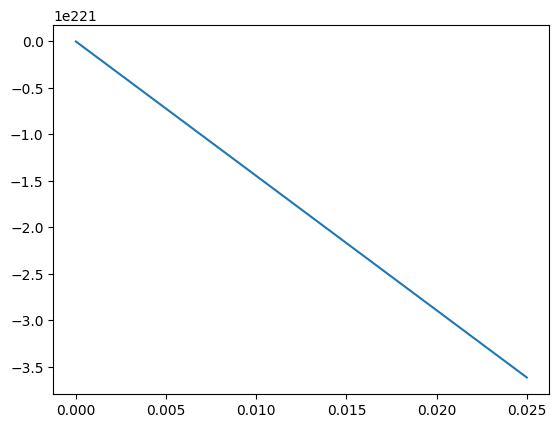

In [58]:
plt.plot(sol.ts, sol.ys[0]["v"])

In [20]:
branch = Branch([Compartment()]*100)
branch.record("v")
branch.add(Leak())
branch.add(Na())
branch.add(K())
branch.comp(0).stimulate(lambda t, u, p: 0.05)
branch.comp(1).stimulate(lambda t, u, p: -0.05)

t0 = 0
p = branch.params
u0 = branch.init(t0, branch.states, branch.params)
branch.set("v", -70.0)

In [21]:
ode = ODETerm(branch.vf)
tspan = (0, 20)
ts = jnp.arange(*tspan, 0.025)
saveat = SaveAt(ts = ts)
sol = diffeqsolve(ode, Dopri5(), *tspan, y0 = u0, dt0 = 0.025, saveat = saveat, args = p)

KeyboardInterrupt: 